In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

df = pd.read_csv('/cleaned_Airbnb_data.csv',low_memory=False)

#Dropping columns that cannot be converted to numeric
columns_to_drop = ['id','amenities', 'description', 'name','thumbnail_url', 'host_since','first_review', 'last_review']
df_cleaned = df.drop(columns=columns_to_drop)

#One-hot encoding for categorical features
categorical_features = ['property_type', 'room_type', 'bed_type', 'city', 'neighbourhood']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_features, drop_first=True)




In [16]:
# Defining feature and target variable
X = df_encoded.drop(columns=['log_price'])  # feature
y = df_encoded['log_price']   # Target variable


# Split into training (60%), validation and testing (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (44466, 681)
Validation set size: (14822, 681)
Testing set size: (14823, 681)


In [7]:
# Using Ridge Regression Model
#Initialize model
rg = Ridge(random_state=42)

#Hyperparameter tuning for Ridge Regression
param_grid_rg = {'alpha': [0.1, 1, 10,100]}
GridSearchCV_rg = GridSearchCV(rg, param_grid_rg, cv=3, scoring='neg_mean_squared_error')
GridSearchCV_rg.fit(X_train, y_train)

#Best Ridge Model
best_rg_model = GridSearchCV_rg.best_estimator_
print("Best Ridge Parameters:", GridSearchCV_rg.best_params_)

Best Ridge Parameters: {'alpha': 1}


In [9]:
# RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
# rf.fit(X_train, y_train)
# y_val_pred_rf = rf.predict(X_val)

# Hyperparameter tuning for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

GridSearchCV_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
GridSearchCV_rf.fit(X_train, y_train)

# Best RandomForestRegressor model
best_rf_model = GridSearchCV_rf.best_estimator_
print("Best Random Forest Parameters:", GridSearchCV_rf.best_params_)

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
#Evaluate models on the validation set:
def evaluate_model(model, X_val, y_val):
    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    return rmse, mae, r2

#Evaluate Ridge Regression model
rmse_rg, mae_rg, r2_rg = evaluate_model(best_rg_model, X_val, y_val)
print(f"Ridge Regression - RMSE: {rmse_rg:.2f}, MAE: {mae_rg:.2f}, R²: {r2_rg:.2f}")

rmse_rf, mae_rf, r2_rf = evaluate_model(best_rf_model, X_val, y_val)
print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

# rmse_svr, mae_svr, r2_svr = evaluate_model(best_svr_model, X_val, y_val)
# print(f"Support Vector Regressor - RMSE: {rmse_svr:.2f}, MAE: {mae_svr:.2f}, R²: {r2_svr:.2f}")

Ridge Regression - RMSE: 0.42, MAE: 0.31, R²: 0.66
Random Forest - RMSE: 0.39, MAE: 0.28, R²: 0.70


Final Model Test RMSE: 0.3912421565594816
Final Model Test MAE: 0.27994502473475247
Final Model Test R²: 0.7045363102702852


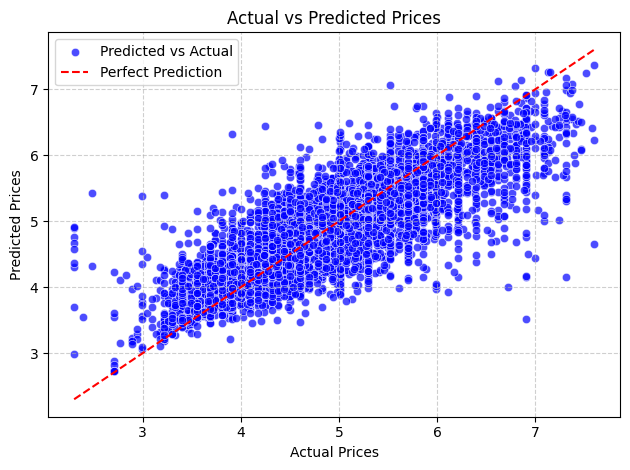

In [21]:
#Final Evaluation on Test Set
# final_model = best_rf_model if rmse_rf < min(rmse_rg, rmse_svr) else (rg if rmse_rg < rmse_svr else best_svr_model)

final_model = best_rf_model if rmse_rf < rmse_rg else best_rg_model
y_test_pred = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Final Model Test RMSE: {rmse_test}")
print(f"Final Model Test MAE: {mae_test}")
print(f"Final Model Test R²: {r2_test}")

actual_prices = np.expm1(y_test)
predicted_prices = np.expm1(y_test_pred)

# Visualize results
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label="Perfect Prediction")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-24-3d04127b70a7>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


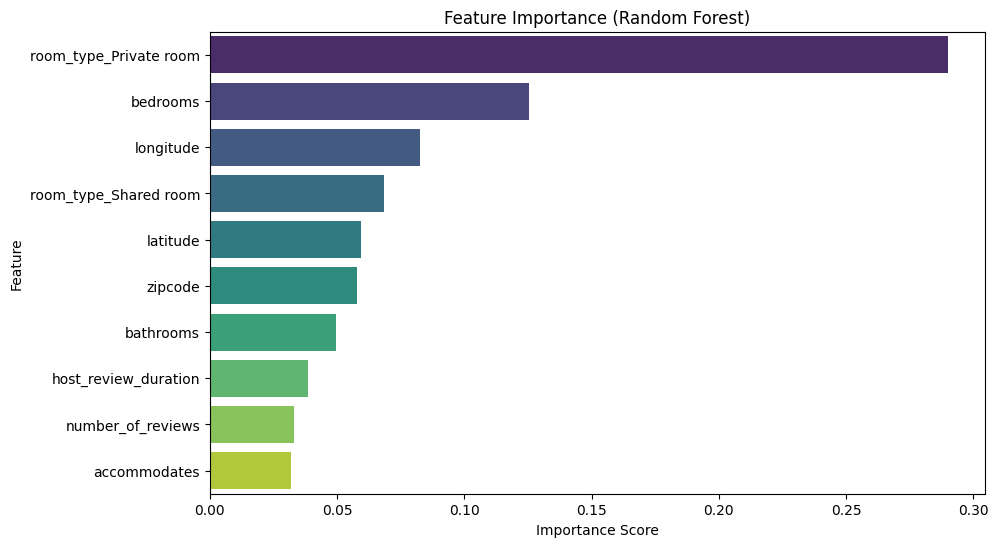

In [24]:
# Extract and plot feature importance for Random Forest
feature_importances = final_model.feature_importances_
feature_names = X_train.columns  # Numeric + categorical feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()